# Problem 2. - pasożytnictwo cieplne

Założenia dla tego problemu są podobne jak poprzednio, jedyne różnice:
- w tym przypadku wartość $U$ dla ścian rozdzielających sąsiadów jest większa (U = 1.0) na podstawie tego samego [linka](https://sip.lex.pl/akty-prawne/dzu-dziennik-ustaw/warunki-techniczne-jakim-powinny-odpowiadac-budynki-i-ich-usytuowanie-16964625)
- zakładamy, że przepływ temperatury między sąsiadami następuje z temperatury przy samej ścianie
- w pierwszej symulacji ogrzewany jest pokój z lewej oraz z prawej strony, ten pośrodku nie ma włączonego kaloryfera, w drugiej wszyscy ogrzewają pokoje

Badać będziemy wykorzystanie energii liczone jako: $$\Psi(t) = \int_{0}^{t} \int_{\Omega} f(x, u(x,s)) \, dx \, ds$$ dla każdego z pokoi.

In [1]:
import sys
from pathlib import Path

NOTEBOOK_DIR = Path().resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent

print("Notebook:", NOTEBOOK_DIR)
print("Project root:", PROJECT_ROOT)

sys.path.insert(0, str(PROJECT_ROOT))
print("Added to sys.path")

Notebook: C:\Users\ameli\Desktop\Studia Programowanie\Ciepło modelowanie\notebooks
Project root: C:\Users\ameli\Desktop\Studia Programowanie\Ciepło modelowanie
Added to sys.path


c:\Users\ameli\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
100%|██████████| 86400/86400 [01:49<00:00, 791.78it/s] 



--- Statystyki: Pokój pierwszy ---
Średnia: 25.17°C
Sigma (std): 14.31°C
Max: 66.81°C | Min: -8.48°C

--- Statystyki: Pokój drugi ---
Średnia: 3.67°C
Sigma (std): 3.12°C
Max: 9.90°C | Min: -5.59°C

--- Statystyki: Pokój trzeci ---
Średnia: 25.17°C
Sigma (std): 14.31°C
Max: 66.81°C | Min: -8.48°C


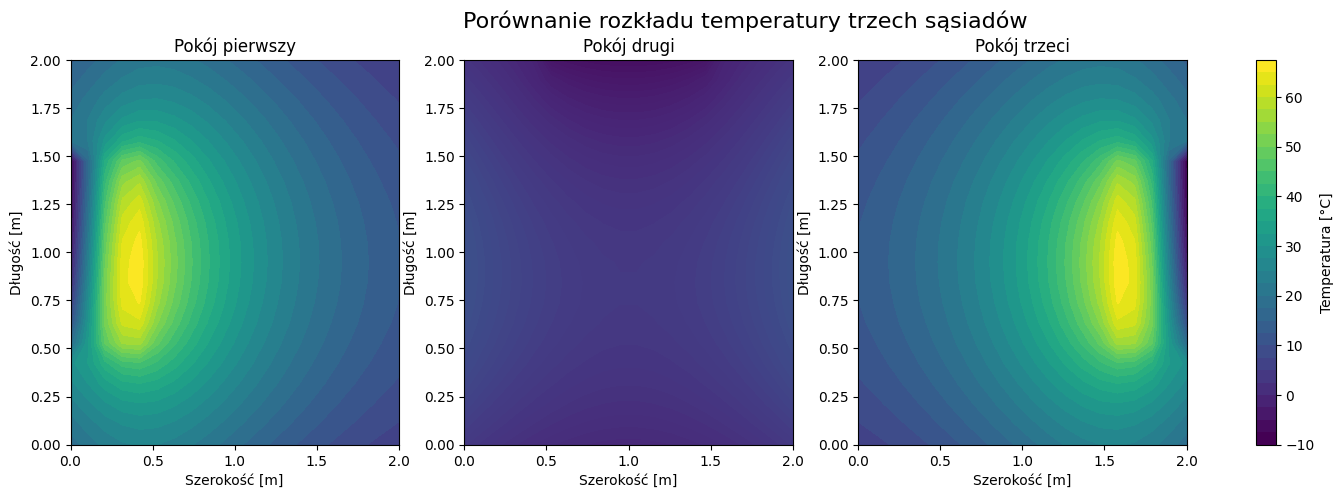

Zużycie energii w pierwszym pokoju: 719.6826001358997
Zużycie energii w drugim pokoju: 0.0
Zużycie energii w trzecim pokoju: 719.6826001357715


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from pipelines.room import Room
from pipelines.heater import Heater
from pipelines.heatercontroller import HeaterController
from pipelines.boundaryconditions import BoundaryConditions
from pipelines.heatsolver import HeatSolver
import matplotlib.animation as animation

room_width = 2.0
room_length = 2.0

c = 1005.0
p = 101325.0
P = 915.0
r = 287.05

U_window = 0.9
U_wall = 0.2
U_wall_inside = 1.0
lambda_air = 0.0262

ht = 1.0
T = 3600.0 * 24
t = np.arange(0, T, ht)

Nx, Ny = 20, 20
x = np.linspace(0, room_width, Nx)
y = np.linspace(0, room_length, Ny)
hx, hy = x[1] - x[0], y[1] - y[0]
room1 = Room(Nx, Ny, hx, hy, 0, 0, room_width, room_length)
room2 = Room(Nx, Ny, hx, hy, 0, 0, room_width, room_length)
room3 = Room(Nx, Ny, hx, hy, 0, 0, room_width, room_length)
lambda_wall = U_wall * hx
lambda_wall_inside = U_wall_inside * hx
lambda_window = U_window * hx

X, Y = np.meshgrid(x, y)
X_flat, Y_flat = X.flatten(), Y.flatten()

T_out = 263.0
T_initial = 293.0
T_target = 298.0

window_width = 1.0
window_center = room_width / 2
window_x_min = window_center - window_width / 2
window_x_max = window_center + window_width / 2
ind_window1 = np.where((X_flat == x[0]) & (Y_flat >= window_x_min) & (Y_flat <= window_x_max), True, False)
ind_window2 = np.where((Y_flat == y[-1]) & (X_flat >= window_x_min) & (X_flat <= window_x_max), True, False)
ind_window3 = np.where((X_flat == x[-1]) & (Y_flat >= window_x_min) & (Y_flat <= window_x_max), True, False)
room1.add_window("left", ind_window1, lambda_window)
room2.add_window("top", ind_window2, lambda_window)
room3.add_window("right", ind_window3, lambda_window)

ind_left = np.where(X_flat == x[0], True, False)
ind_left1 = np.where(X_flat == x[0], True, False) & ~ind_window1
ind_right = np.where(X_flat == x[-1], True, False)
ind_right3 = np.where(X_flat == x[-1], True, False) & ~ind_window3
ind_bottom = np.where(Y_flat == y[0], True, False)
ind_top = np.where(Y_flat == y[-1], True, False)
ind_top2 = np.where(Y_flat == y[-1], True, False) & ~ind_window2
room1.add_walls("left", ind_left1, lambda_wall)
room1.add_walls("right", ind_right, lambda_wall_inside)
room1.add_walls("bottom", ind_bottom, lambda_wall)
room1.add_walls("top", ind_top, lambda_wall)
room2.add_walls("left", ind_left, lambda_wall_inside)
room2.add_walls("right", ind_right, lambda_wall_inside)
room2.add_walls("bottom", ind_bottom, lambda_wall)
room2.add_walls("top", ind_top2, lambda_wall)
room3.add_walls("left", ind_left, lambda_wall_inside)
room3.add_walls("right", ind_right3, lambda_wall)
room3.add_walls("bottom", ind_bottom, lambda_wall)
room3.add_walls("top", ind_top, lambda_wall)

room1.add_neighbor("right", room2)
room2.add_neighbor("left", room1)
room2.add_neighbor("right", room3)
room3.add_neighbor("left", room2)

radiator_width = 1.0
offset = 2 * hy
rad_x_min = window_center - radiator_width / 2
rad_x_max = window_center + radiator_width / 2

radiator_height = radiator_width
rad_y_center = room_length / 2
rad_y_min = rad_y_center - radiator_height / 2
rad_y_max = rad_y_center + radiator_height / 2

ind_radiator_left = (X_flat >= offset) & (X_flat < offset + 3 * hx) & (Y_flat >= rad_y_min) & (Y_flat <= rad_y_max)
heater_left = Heater(ind_radiator_left, P, T_target)
room1.add_heater("heater", heater_left)
ind_radiator_right = (X_flat <= room_length - offset) & (X_flat > room_length - offset - 3 * hx) & (Y_flat >= rad_y_min) & (Y_flat <= rad_y_max)
heater_right = Heater(ind_radiator_right, P, T_target)
room3.add_heater("heater", heater_right)

bc1 = BoundaryConditions(room1)
bc2 = BoundaryConditions(room2)
bc3 = BoundaryConditions(room3)
solver1 = HeatSolver(room1, ht)
solver1.apply_boundary_conditions(bc1)
solver2 = HeatSolver(room2, ht)
solver2.apply_boundary_conditions(bc2)
solver3 = HeatSolver(room3, ht)
solver3.apply_boundary_conditions(bc3)

controller1 = HeaterController(room1)
controller2 = HeaterController(room2)
controller3 = HeaterController(room3)

u0 = np.ones(Nx * Ny) * 290
u_current1 = np.zeros(len(u0))
u_current2 = np.zeros(len(u0))
u_current3 = np.zeros(len(u0))

energy_usage1 = []
energy_usage2 = []
energy_usage3 = []

history1 = []
history2 = []
history3 = []
save_interval = 60

room1.last_u = u0.copy()
room2.last_u = u0.copy()
room3.last_u = u0.copy()

energy_usage1, energy_usage2, energy_usage3 = [], [], []
history1, history2, history3 = [], [], []
save_interval = 60

for time in tqdm.tqdm(t):
    source1 = controller1.compute_source(room1.last_u)
    source2 = controller2.compute_source(room2.last_u)
    source3 = controller3.compute_source(room3.last_u)

    energy_usage1.append(np.sum(source1) * hx * hy)
    energy_usage2.append(np.sum(source2) * hx * hy)
    energy_usage3.append(np.sum(source3) * hx * hy)

    u_next1 = solver1.step(room1.last_u, source1, bc1)
    u_next2 = solver2.step(room2.last_u, source2, bc2)
    u_next3 = solver3.step(room3.last_u, source3, bc3)

    room1.last_u = u_next1
    room2.last_u = u_next2
    room3.last_u = u_next3

    if int(time) % save_interval == 0:
        history1.append(room1.last_u.reshape(Nx, Ny).copy())
        history2.append(room2.last_u.reshape(Nx, Ny).copy())
        history3.append(room3.last_u.reshape(Nx, Ny).copy())

u_current1 = room1.last_u - 273.0
u_current2 = room2.last_u - 273.0
u_current3 = room3.last_u - 273.0

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
results = [u_current1, u_current2, u_current3]
titles = ["Pokój pierwszy", "Pokój drugi", "Pokój trzeci"]

vmin = min(u.min() for u in results)
vmax = max(u.max() for u in results)

for i, ax in enumerate(axes):
    u_2d = results[i].reshape(Nx, Ny)

    im = ax.contourf(x, y, u_2d, levels=30, vmin=vmin, vmax=vmax)
    ax.set_title(titles[i])
    ax.set_xlabel("Szerokość [m]")
    ax.set_ylabel("Długość [m]")

    print(f"\n--- Statystyki: {titles[i]} ---")
    print(f"Średnia: {np.mean(results[i]):.2f}°C")
    print(f"Sigma (std): {np.std(results[i]):.2f}°C")
    print(f"Max: {results[i].max():.2f}°C | Min: {results[i].min():.2f}°C")

fig.colorbar(im, ax=axes.ravel().tolist(), label="Temperatura [°C]")
plt.suptitle("Porównanie rozkładu temperatury trzech sąsiadów", fontsize=16)

plt.show()
print(f"Zużycie energii w pierwszym pokoju: {np.sum(energy_usage1) * ht}")
print(f"Zużycie energii w drugim pokoju: {np.sum(energy_usage2) * ht}")
print(f"Zużycie energii w trzecim pokoju: {np.sum(energy_usage3) * ht}")

100%|██████████| 86400/86400 [01:01<00:00, 1402.28it/s]



--- Statystyki: Pokój pierwszy ---
Średnia: 25.11°C
Sigma (std): 10.09°C
Max: 54.82°C | Min: -8.69°C

--- Statystyki: Pokój drugi ---
Średnia: 25.17°C
Sigma (std): 8.87°C
Max: 48.89°C | Min: 11.10°C

--- Statystyki: Pokój trzeci ---
Średnia: 25.11°C
Sigma (std): 10.09°C
Max: 54.82°C | Min: -8.69°C


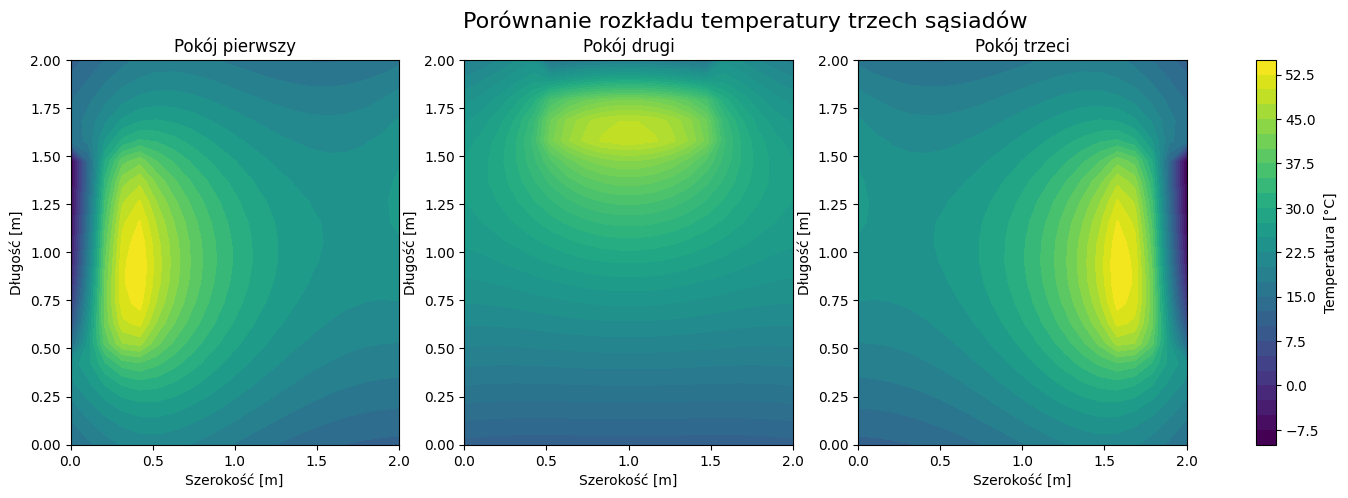

Zużycie energii w pierwszym pokoju: 614.8299583337591
Zużycie energii w drugim pokoju: 385.89176968088924
Zużycie energii w trzecim pokoju: 614.829958333649


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from pipelines.room import Room
from pipelines.heater import Heater
from pipelines.heatercontroller import HeaterController
from pipelines.boundaryconditions import BoundaryConditions
from pipelines.heatsolver import HeatSolver
import matplotlib.animation as animation

room_width = 2.0
room_length = 2.0

c = 1005.0
p = 101325.0
P = 915.0
r = 287.05

U_window = 0.9
U_wall = 0.2
U_wall_inside = 1.0
lambda_air = 0.0262

ht = 1.0
T = 3600.0 * 24
t = np.arange(0, T, ht)

Nx, Ny = 20, 20
x = np.linspace(0, room_width, Nx)
y = np.linspace(0, room_length, Ny)
hx, hy = x[1] - x[0], y[1] - y[0]
room1 = Room(Nx, Ny, hx, hy, 0, 0, room_width, room_length)
room2 = Room(Nx, Ny, hx, hy, 0, 0, room_width, room_length)
room3 = Room(Nx, Ny, hx, hy, 0, 0, room_width, room_length)
lambda_wall = U_wall * hx
lambda_wall_inside = U_wall_inside * hx
lambda_window = U_window * hx

X, Y = np.meshgrid(x, y)
X_flat, Y_flat = X.flatten(), Y.flatten()

T_out = 263.0
T_initial = 293.0
T_target = 298.0

window_width = 1.0
window_center = room_width / 2
window_x_min = window_center - window_width / 2
window_x_max = window_center + window_width / 2
ind_window1 = np.where((X_flat == x[0]) & (Y_flat >= window_x_min) & (Y_flat <= window_x_max), True, False)
ind_window2 = np.where((Y_flat == y[-1]) & (X_flat >= window_x_min) & (X_flat <= window_x_max), True, False)
ind_window3 = np.where((X_flat == x[-1]) & (Y_flat >= window_x_min) & (Y_flat <= window_x_max), True, False)
room1.add_window("left", ind_window1, lambda_window)
room2.add_window("top", ind_window2, lambda_window)
room3.add_window("right", ind_window3, lambda_window)

ind_left = np.where(X_flat == x[0], True, False)
ind_left1 = np.where(X_flat == x[0], True, False) & ~ind_window1
ind_right = np.where(X_flat == x[-1], True, False)
ind_right3 = np.where(X_flat == x[-1], True, False) & ~ind_window3
ind_bottom = np.where(Y_flat == y[0], True, False)
ind_top = np.where(Y_flat == y[-1], True, False)
ind_top2 = np.where(Y_flat == y[-1], True, False) & ~ind_window2
room1.add_walls("left", ind_left1, lambda_wall)
room1.add_walls("right", ind_right, lambda_wall_inside)
room1.add_walls("bottom", ind_bottom, lambda_wall)
room1.add_walls("top", ind_top, lambda_wall)
room2.add_walls("left", ind_left, lambda_wall_inside)
room2.add_walls("right", ind_right, lambda_wall_inside)
room2.add_walls("bottom", ind_bottom, lambda_wall)
room2.add_walls("top", ind_top2, lambda_wall)
room3.add_walls("left", ind_left, lambda_wall_inside)
room3.add_walls("right", ind_right3, lambda_wall)
room3.add_walls("bottom", ind_bottom, lambda_wall)
room3.add_walls("top", ind_top, lambda_wall)

room1.add_neighbor("right", room2)
room2.add_neighbor("left", room1)
room2.add_neighbor("right", room3)
room3.add_neighbor("left", room2)

radiator_width = 1.0
offset = 2 * hy
rad_x_min = window_center - radiator_width / 2
rad_x_max = window_center + radiator_width / 2

radiator_height = radiator_width
rad_y_center = room_length / 2
rad_y_min = rad_y_center - radiator_height / 2
rad_y_max = rad_y_center + radiator_height / 2

ind_radiator_left = (X_flat >= offset) & (X_flat < offset + 3 * hx) & (Y_flat >= rad_y_min) & (Y_flat <= rad_y_max)
heater_left = Heater(ind_radiator_left, P, T_target)
room1.add_heater("heater", heater_left)
ind_radiator_right = (X_flat <= room_length - offset) & (X_flat > room_length - offset - 3 * hx) & (Y_flat >= rad_y_min) & (Y_flat <= rad_y_max)
heater_right = Heater(ind_radiator_right, P, T_target)
room3.add_heater("heater", heater_right)
ind_radiator_top = (Y_flat <= room_width - offset) & (Y_flat > room_width - offset - 3 * hy) & (X_flat >= rad_x_min) & (X_flat <= rad_x_max)
heater_top = Heater(ind_radiator_top, P, T_target)
room2.add_heater("heater", heater_top)

bc1 = BoundaryConditions(room1)
bc2 = BoundaryConditions(room2)
bc3 = BoundaryConditions(room3)
solver1 = HeatSolver(room1, ht)
solver1.apply_boundary_conditions(bc1)
solver2 = HeatSolver(room2, ht)
solver2.apply_boundary_conditions(bc2)
solver3 = HeatSolver(room3, ht)
solver3.apply_boundary_conditions(bc3)

controller1 = HeaterController(room1)
controller2 = HeaterController(room2)
controller3 = HeaterController(room3)

u0 = np.ones(Nx * Ny) * 290
u_current1 = np.zeros(len(u0))
u_current2 = np.zeros(len(u0))
u_current3 = np.zeros(len(u0))

energy_usage1 = []
energy_usage2 = []
energy_usage3 = []

history1 = []
history2 = []
history3 = []
save_interval = 60

room1.last_u = u0.copy()
room2.last_u = u0.copy()
room3.last_u = u0.copy()

energy_usage1, energy_usage2, energy_usage3 = [], [], []
history1, history2, history3 = [], [], []
save_interval = 60

for time in tqdm.tqdm(t):
    source1 = controller1.compute_source(room1.last_u)
    source2 = controller2.compute_source(room2.last_u)
    source3 = controller3.compute_source(room3.last_u)

    energy_usage1.append(np.sum(source1) * hx * hy)
    energy_usage2.append(np.sum(source2) * hx * hy)
    energy_usage3.append(np.sum(source3) * hx * hy)

    u_next1 = solver1.step(room1.last_u, source1, bc1)
    u_next2 = solver2.step(room2.last_u, source2, bc2)
    u_next3 = solver3.step(room3.last_u, source3, bc3)

    room1.last_u = u_next1
    room2.last_u = u_next2
    room3.last_u = u_next3

    if int(time) % save_interval == 0:
        history1.append(room1.last_u.reshape(Nx, Ny).copy())
        history2.append(room2.last_u.reshape(Nx, Ny).copy())
        history3.append(room3.last_u.reshape(Nx, Ny).copy())

u_current1 = room1.last_u - 273.0
u_current2 = room2.last_u - 273.0
u_current3 = room3.last_u - 273.0

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
results = [u_current1, u_current2, u_current3]
titles = ["Pokój pierwszy", "Pokój drugi", "Pokój trzeci"]

vmin = min(u.min() for u in results)
vmax = max(u.max() for u in results)

for i, ax in enumerate(axes):
    u_2d = results[i].reshape(Nx, Ny)

    im = ax.contourf(x, y, u_2d, levels=30, vmin=vmin, vmax=vmax)
    ax.set_title(titles[i])
    ax.set_xlabel("Szerokość [m]")
    ax.set_ylabel("Długość [m]")

    print(f"\n--- Statystyki: {titles[i]} ---")
    print(f"Średnia: {np.mean(results[i]):.2f}°C")
    print(f"Sigma (std): {np.std(results[i]):.2f}°C")
    print(f"Max: {results[i].max():.2f}°C | Min: {results[i].min():.2f}°C")

fig.colorbar(im, ax=axes.ravel().tolist(), label="Temperatura [°C]")
plt.suptitle("Porównanie rozkładu temperatury trzech sąsiadów", fontsize=16)

plt.show()
print(f"Zużycie energii w pierwszym pokoju: {np.sum(energy_usage1) * ht}")
print(f"Zużycie energii w drugim pokoju: {np.sum(energy_usage2) * ht}")
print(f"Zużycie energii w trzecim pokoju: {np.sum(energy_usage3) * ht}")

Jak widać, porównując do siebie dwie symulacje, w pierwszym przypadku pokój środkowy jest zimny, a w pozostałych dwóch pokojach również trudniej jest "nadrobić" straty z pokoju środkowego. W drugim przypadku zużycie energii jest mniejsze dla pokoi grzejących, a pokój środkowy nadal ma najmniejsze zużycie. Jednocześnie we wszystkich pokojach jest ciepło.